# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Read Solar Energy Production Dataset

In [2]:
data = pd.read_csv('F:\APU\FYP\Dataset\Cleaned_data\solar_production_dataset.csv')

data.head()

,Country,Date,Value,Daylight,Temperature,GHI,DNI
0,Australia,2023-03-01,4055.6634,734.69403,26.204160,894897.94,693884.56
1,Australia,2023-02-01,4466.4801,778.22370,27.318323,997130.10,756902.75
2,Australia,2023-01-01,4967.0119,812.18915,27.128540,1009778.60,739408.44
3,Australia,2022-12-01,5179.1465,822.62040,26.521873,1087540.60,817223.80
4,Australia,2022-11-01,4548.5315,801.65320,23.784800,1055200.00,791037.10


## Extract Data for each country

In [3]:
countries = data['Country'].unique()

solar_production_data = {}

# use loc() function to select data from a DataFrame based on specified row and column labels or conditions.
# Iterate over the countries
for country in countries:
    # Filter the data for the current country and 'solar' product
    country_energy_production = data.loc[
        (data['Country'] == country), ['Date', 'Value', 'Daylight', 'Temperature', 'GHI', 'DNI']
    ]
    
    # Store the filtered data in the dictionary
    solar_production_data[country] = country_energy_production.reset_index(drop=True)

solar_production_data["People's Republic of China"]

,Date,Value,Daylight,Temperature,GHI,DNI
0,2023-03-01,45409.2845,717.45917,4.099189,753415.94,517775.80
1,2023-02-01,35862.9013,650.94720,-2.161056,556252.10,368314.62
2,2023-01-01,33219.6075,598.98047,-6.828498,465389.72,332214.78
3,2022-12-01,30214.3452,582.81866,-6.478275,407466.30,283585.10
4,2022-11-01,29443.7450,614.86520,1.722475,443593.40,296289.50
...,...,...,...,...,...,...
94,2015-05-01,3195.2610,846.25793,13.962502,930306.90,594858.60
95,2015-04-01,3195.2610,787.00870,8.645202,888382.60,579006.70
96,2015-03-01,3195.2610,717.32870,2.950874,740123.25,499648.66
97,2015-02-01,3195.2610,650.84265,-2.838640,573129.30,388836.90


# Resample to daily data

In [4]:
# hypro_production_data
for country_data in solar_production_data:
    
    # set time as the index
    solar_production_data[country_data]['Date'] = pd.to_datetime(solar_production_data[country_data]['Date'])
    solar_production_data[country_data].set_index('Date', inplace=True)
    
    # divide the monthly statistical production value by the number of days 
    # of the month to get the avarage daily production value
    solar_production_data[country_data]['Value'] = (solar_production_data[country_data]['Value']/
                                                    solar_production_data[country_data].index.days_in_month)
    
    # resample the monthly index to daily and impute the missing value with linear interpolate method
    daily_data = solar_production_data[country_data].resample('D').interpolate('linear')
    solar_production_data[country_data] = daily_data
    
solar_production_data["People's Republic of China"]

,Value,Daylight,Temperature,GHI,DNI
Date,,,,,
2015-01-01,103.072935,598.932200,-6.002148,447612.800000,304913.750000
2015-01-02,103.429178,600.606731,-5.900099,451661.719355,307620.948387
2015-01-03,103.785421,602.281261,-5.798050,455710.638710,310328.146774
2015-01-04,104.141664,603.955792,-5.696002,459759.558065,313035.345161
2015-01-05,104.497907,605.630323,-5.593953,463808.477419,315742.543548
...,...,...,...,...,...
2023-02-25,1438.530240,707.957460,3.204869,725249.677143,496424.202857
2023-02-26,1445.101587,710.332887,3.428449,732291.242857,501762.102143
2023-02-27,1451.672934,712.708315,3.652029,739332.808571,507100.001429


# Model Building

### Split train and test data

In [5]:
data = solar_production_data["People's Republic of China"]

# Split the data into training and testing sets
split_date = '2021-01-01'
train, test = data[:split_date], data[split_date:]

print(train.head())
print(train.shape)
print()
print(test.head())
print(test.shape)

                 Value    Daylight  Temperature            GHI            DNI
Date                                                                         
2015-01-01  103.072935  598.932200    -6.002148  447612.800000  304913.750000
2015-01-02  103.429178  600.606731    -5.900099  451661.719355  307620.948387
2015-01-03  103.785421  602.281261    -5.798050  455710.638710  310328.146774
2015-01-04  104.141664  603.955792    -5.696002  459759.558065  313035.345161
2015-01-05  104.497907  605.630323    -5.593953  463808.477419  315742.543548
(2193, 5)

                 Value   Daylight  Temperature            GHI            DNI
Date                                                                        
2021-01-01  697.949481  599.61540    -6.973590  465940.300000  330186.160000
2021-01-02  703.615319  601.30445    -6.788597  469722.719355  332597.281935
2021-01-03  709.281157  602.99350    -6.603604  473505.138710  335008.403871
2021-01-04  714.946996  604.68255    -6.418611  477287.558

## Univariate Model - ARIMA - Daily

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

#### The developer has use R with the auto.arima() function to identify the p, q, d value of the best fit ARIMA model for this dataset, the result shows that the order(p, q, d) = (2,1,3)(0,1,0)[365] 

#### Figure below show the result from R:
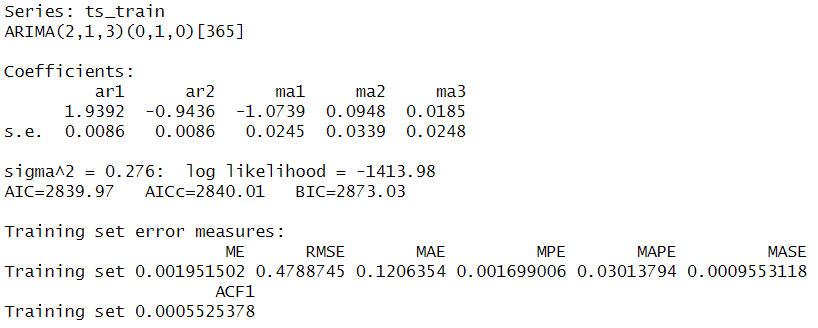

In [51]:
import rpy2.robjects as robjects
# Load the 'forecast' R package
robjects.r("library(forecast)")

# Load the ARIMA model
r_load = robjects.r['readRDS']
chn_solar_arima_model = r_load(r"F:\APU\FYP\SEM 2\Report Doc\R script\chn_solar_arima_model.rds")

R[write to console]: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: package 'forecast' was built under R version 4.1.3 



In [52]:
# Generate predictions
r_forecast = robjects.r['forecast']
predictions = r_forecast(chn_solar_arima_model, h=len(test))

# Evaluate the model performance
print("Mean Absolute Error: ", mean_absolute_error(predictions.rx('mean')[0], test['Value'].values))
mse = mean_squared_error(predictions.rx('mean')[0], test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", math.sqrt(mse))

Mean Absolute Error:  163.25903074778904
Mean Squared Error:  37118.285008070525
Root Mean Squared Error:  192.66106251152704


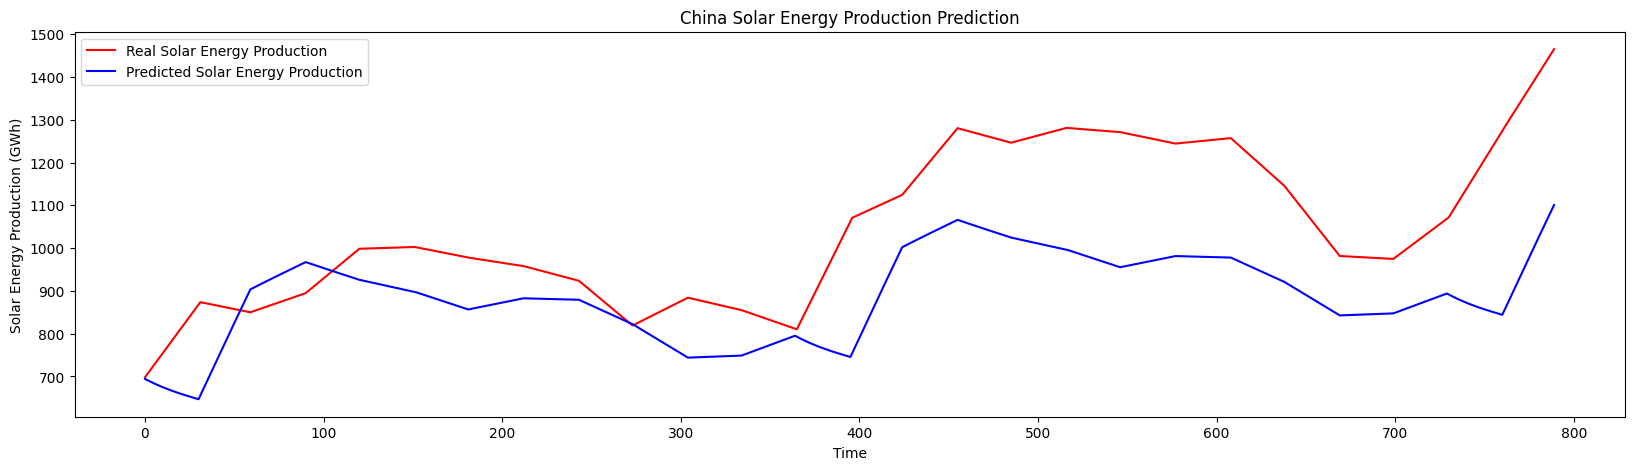

In [53]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Solar Energy Production')
plt.plot(predictions.rx('mean')[0], color = 'blue', label = 'Predicted Solar Energy Production')
plt.title('China Solar Energy Production Prediction')
plt.xlabel('Time')
plt.ylabel('Solar Energy Production (GWh)')
plt.legend()
plt.show()

## SVM - Univariate

In [10]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [84]:
# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['Value']].values)
test_scaled = scaler.transform(test[['Value']].values)

# Reshape the input data
time_steps = 365  # Define the number of previous time steps to consider

# Creating a data structure with 365 timestamps and 1 output
x_train = []
y_train = []
for i in range(time_steps, len(train)):
    x_train.append(train_scaled[i-time_steps:i, 0])
    y_train.append(train_scaled[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train.shape, y_train.shape)

(1828, 365) (1828,)


In [85]:
# Build and Train the SVM Model
chn_daily_svr = SVR(kernel='linear',gamma=0.5, C=0.1, epsilon = 0.01) # Specify hyperparameters
chn_daily_svr.fit(x_train, y_train)

SVR(C=0.1, epsilon=0.01, gamma=0.5, kernel='linear')

In [86]:
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
x_test = []
for i in range(time_steps, len(test)+time_steps):
    x_test.append(inputs[i-time_steps:i, 0])
x_test = np.array(x_test)

# Predict Solar Energy Production
svr_y_pred = chn_daily_svr.predict(x_test).reshape(-1,1)
svr_y_pred = scaler.inverse_transform(svr_y_pred)
print(svr_y_pred.shape)

(790, 1)


In [87]:
print(inputs)

[[0.64506272]
 [0.64309435]
 [0.64112598]
 ...
 [1.76300071]
 [1.77159131]
 [1.78018192]]


In [88]:
# Evaluate the model
print("Mean Absolute Error: ", mean_absolute_error(svr_y_pred, test['Value'].values))
mse = mean_squared_error(svr_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  8.084459309373747
Mean Squared Error:  85.89822585657832
Root Mean Squared Error:  9.268129577027844


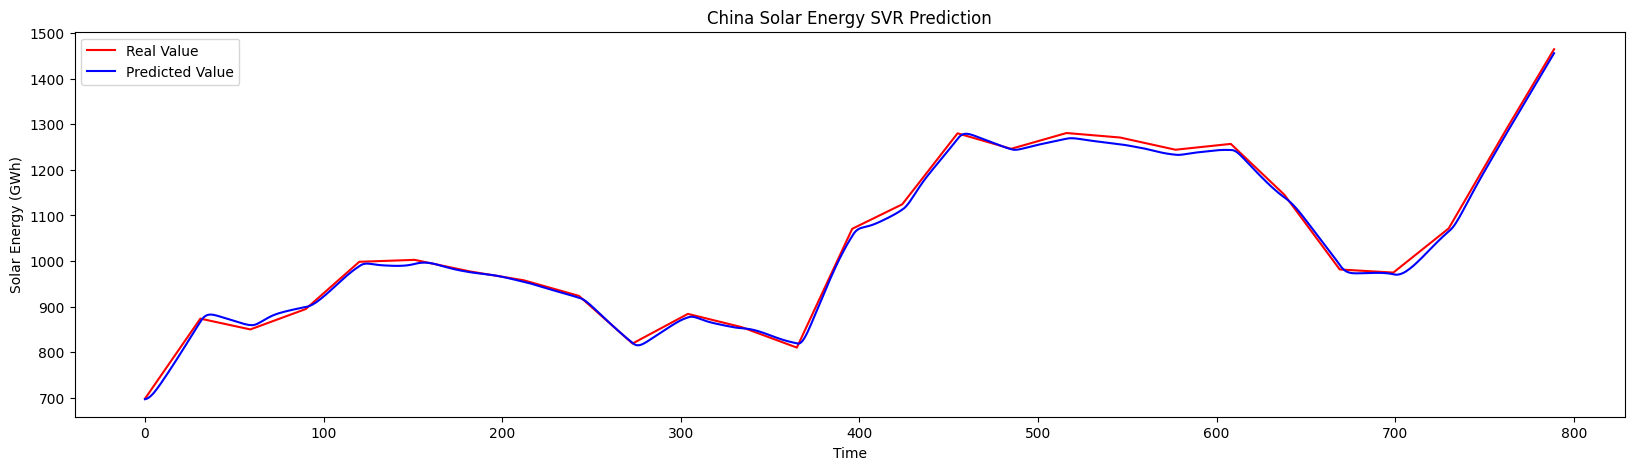

In [89]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color='red', label='Real Value')
plt.plot(svr_y_pred, color='blue', label='Predicted Value')
plt.title('China Solar Energy SVR Prediction')
plt.xlabel('Time')
plt.ylabel('Solar Energy (GWh)')
plt.legend()
plt.show()

## Univariate GRU - Daily

In [60]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train[['Value']].values)

In [61]:
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

# Set the number of time steps (input sequence length)
time_steps = 365

# Create the training datasets
X_train, y_train = create_dataset(training_set_scaled, time_steps)

# Create the testing datasets
X_test, y_test = create_dataset(test['Value'].values, time_steps)

In [19]:
from keras.models import Sequential
from keras.layers import GRU, Dense

# Create the model
chn_daily_gru = Sequential()
chn_daily_gru.add(GRU(units=64, return_sequences=True, input_shape=(time_steps, 1)))
chn_daily_gru.add(GRU(units=64))
chn_daily_gru.add(Dense(1, activation='linear'))

chn_daily_gru.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
chn_daily_gru.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
58/58 [==============================] - 81s 655ms/step - loss: 0.0126
Epoch 2/100
58/58 [==============================] - 35s 612ms/step - loss: 1.0021e-04
Epoch 3/100
58/58 [==============================] - 39s 667ms/step - loss: 7.1070e-05
Epoch 4/100
58/58 [==============================] - 39s 678ms/step - loss: 6.1801e-05
Epoch 5/100
58/58 [==============================] - 45s 785ms/step - loss: 5.4985e-05
Epoch 6/100
58/58 [==============================] - 43s 742ms/step - loss: 4.9404e-05
Epoch 7/100
58/58 [==============================] - 41s 700ms/step - loss: 4.4150e-05
Epoch 8/100
58/58 [==============================] - 41s 700ms/step - loss: 4.1298e-05
Epoch 9/100
58/58 [==============================] - 38s 652ms/step - loss: 4.0271e-05
Epoch 10/100
58/58 [==============================] - 37s 643ms/step - loss: 3.5881e-05
Epoch 11/100
58/58 [==============================] - 43s 738ms/step - loss: 2.8976e-05
Epoch 12/100
58/58 [=========================

58/58 [==============================] - 50s 847ms/step - loss: 3.5747e-06
Epoch 95/100
58/58 [==============================] - 46s 794ms/step - loss: 5.3910e-06
Epoch 96/100
58/58 [==============================] - 50s 866ms/step - loss: 5.2037e-06
Epoch 97/100
58/58 [==============================] - 51s 869ms/step - loss: 1.0001e-05
Epoch 98/100
58/58 [==============================] - 50s 861ms/step - loss: 6.0628e-06
Epoch 99/100
58/58 [==============================] - 43s 742ms/step - loss: 1.4135e-05
Epoch 100/100
58/58 [==============================] - 49s 838ms/step - loss: 2.8051e-05


In [62]:
# Getting the predicted value
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(time_steps, len(test)+time_steps):
    X_test.append(inputs[i-time_steps:i, 0])
X_test = np.array(X_test)

gru_y_pred = chn_daily_gru.predict(X_test)
gru_y_pred = sc.inverse_transform(gru_y_pred)

25/25 [==============================] - 60s 668ms/step


In [63]:
print("Mean Absolute Error: ", mean_absolute_error(gru_y_pred, test['Value'].values))
mse = mean_squared_error(gru_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  4.235241707606294
Mean Squared Error:  20.150159521601438
Root Mean Squared Error:  4.488892906007163


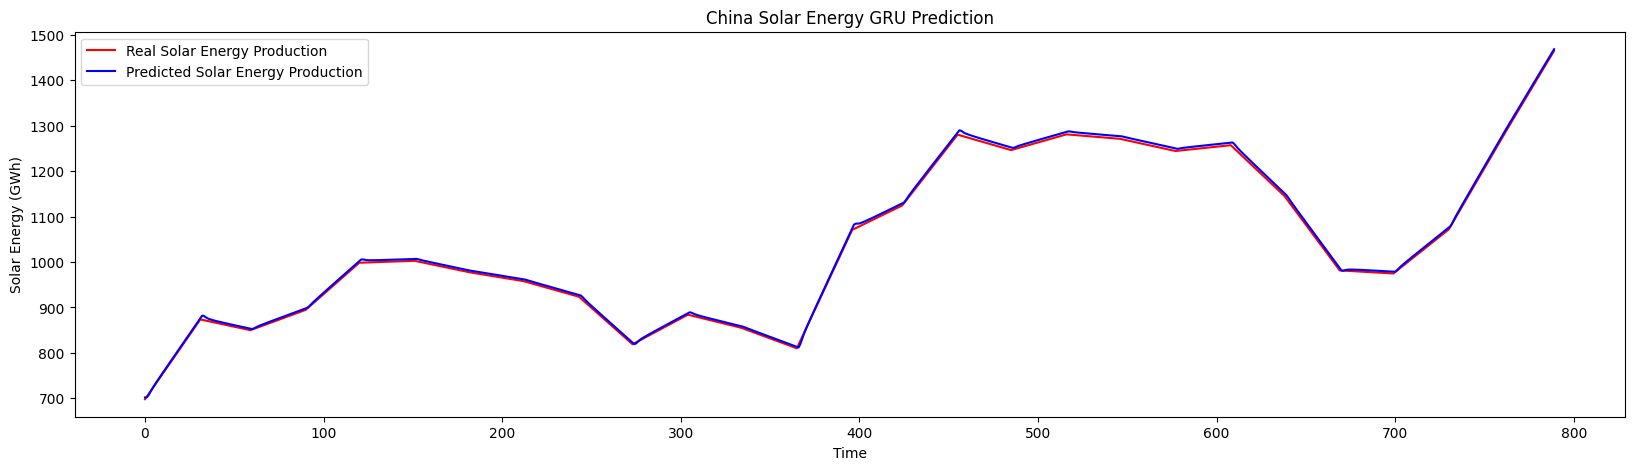

In [64]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Solar Energy Production')
plt.plot(gru_y_pred, color = 'blue', label = 'Predicted Solar Energy Production')
plt.title('China Solar Energy GRU Prediction')
plt.xlabel('Time')
plt.ylabel('Solar Energy (GWh)')
plt.legend()
plt.show()

## Univariate LSTM - Daily

In [65]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train[['Value']].values)

print(training_set_scaled)
print(training_set_scaled.shape)

[[0.00000000e+00]
 [4.65709938e-04]
 [9.31419876e-04]
 ...
 [7.73623570e-01]
 [7.75647529e-01]
 [7.77671489e-01]]
(2193, 1)


In [66]:
# Creating a data structure with 365 timestamps and 1 output
X_train = []
y_train = []
for i in range(time_steps, len(train)):
    X_train.append(training_set_scaled[i-time_steps:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [67]:
print(X_train)
X_train.shape

[[0.00000000e+00 4.65709938e-04 9.31419876e-04 ... 7.70966505e-02
  7.98501023e-02 8.26035541e-02]
 [4.65709938e-04 9.31419876e-04 1.39712981e-03 ... 7.98501023e-02
  8.26035541e-02 8.53570059e-02]
 [9.31419876e-04 1.39712981e-03 1.86283975e-03 ... 8.26035541e-02
  8.53570059e-02 8.35148983e-02]
 ...
 [6.45949277e-01 6.48999460e-01 6.47031091e-01 ... 7.67551692e-01
  7.69575652e-01 7.71599611e-01]
 [6.48999460e-01 6.47031091e-01 6.45062722e-01 ... 7.69575652e-01
  7.71599611e-01 7.73623570e-01]
 [6.47031091e-01 6.45062722e-01 6.43094353e-01 ... 7.71599611e-01
  7.73623570e-01 7.75647529e-01]]


(1828, 365)

In [68]:
print(y_train)
y_train.shape

[0.08535701 0.0835149  0.08167279 ... 0.77362357 0.77564753 0.77767149]


(1828,)

In [69]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [29]:
# Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [30]:
# Initialising the RNN
chn_daily_uni_lstm = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
chn_daily_uni_lstm.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], 1)))
chn_daily_uni_lstm.add(Dropout(0.2))

chn_daily_uni_lstm.add(LSTM(units = 64, return_sequences = True))
chn_daily_uni_lstm.add(Dropout(0.2))

chn_daily_uni_lstm.add(LSTM(units = 64))
chn_daily_uni_lstm.add(Dropout(0.2))

# Adding the output layer
chn_daily_uni_lstm.add(Dense(units = 1))

In [31]:
# Compiling the RNN
chn_daily_uni_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
chn_daily_uni_lstm.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
58/58 [==============================] - 145s 1s/step - loss: 0.0228
Epoch 2/100
58/58 [==============================] - 61s 1s/step - loss: 0.0032
Epoch 3/100
58/58 [==============================] - 65s 1s/step - loss: 0.0027
Epoch 4/100
58/58 [==============================] - 72s 1s/step - loss: 0.0026
Epoch 5/100
58/58 [==============================] - 69s 1s/step - loss: 0.0035
Epoch 6/100
58/58 [==============================] - 70s 1s/step - loss: 0.0023
Epoch 7/100
58/58 [==============================] - 69s 1s/step - loss: 0.0023
Epoch 8/100
58/58 [==============================] - 71s 1s/step - loss: 0.0021
Epoch 9/100
58/58 [==============================] - 68s 1s/step - loss: 0.0025
Epoch 10/100
58/58 [==============================] - 69s 1s/step - loss: 0.0023
Epoch 11/100
58/58 [==============================] - 65s 1s/step - loss: 0.0019
Epoch 12/100
58/58 [==============================] - 68s 1s/step - loss: 0.0020
Epoch 13/100
58/58 [================

58/58 [==============================] - 79s 1s/step - loss: 6.8781e-04
Epoch 100/100
58/58 [==============================] - 75s 1s/step - loss: 5.5626e-04


In [32]:
test[['Value']].shape

(790, 1)

In [70]:
dataset_total = pd.concat((train['Value'], test['Value']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - 365:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(time_steps, len(test)+time_steps):
    X_test.append(inputs[i-time_steps:i, 0])
    y_test.append(inputs[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
uni_lstm_y_pred = chn_daily_uni_lstm.predict(X_test)
uni_lstm_y_pred = sc.inverse_transform(uni_lstm_y_pred)

25/25 [==============================] - 24s 307ms/step


In [71]:
print("Mean Absolute Error: ", mean_absolute_error(uni_lstm_y_pred, test['Value'].values))
mse = mean_squared_error(uni_lstm_y_pred, test['Value'].values)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  19.650255666613337
Mean Squared Error:  509.04340363191807
Root Mean Squared Error:  22.56199024093216


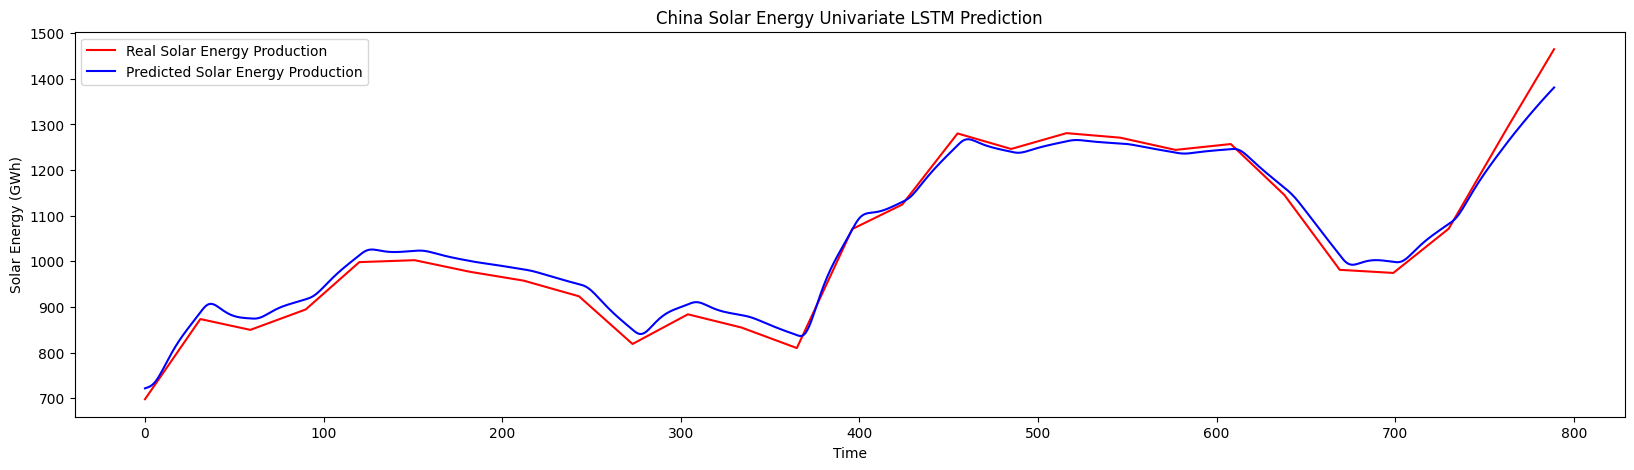

In [72]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(test['Value'].values, color = 'red', label = 'Real Solar Energy Production')
plt.plot(uni_lstm_y_pred, color = 'blue', label = 'Predicted Solar Energy Production')
plt.title('China Solar Energy Univariate LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Solar Energy (GWh)')
plt.legend()
plt.show()

## Multivariate LSTM

In [73]:
data = solar_production_data["People's Republic of China"]

data.shape

(2982, 5)

In [74]:
X = data[['Daylight', 'Temperature', 'GHI', 'DNI', 'Value']]
y = data[['Value']]

X.head()

,Daylight,Temperature,GHI,DNI,Value
Date,,,,,
2015-01-01,598.932200,-6.002148,447612.800000,304913.750000,103.072935
2015-01-02,600.606731,-5.900099,451661.719355,307620.948387,103.429178
2015-01-03,602.281261,-5.798050,455710.638710,310328.146774,103.785421
2015-01-04,603.955792,-5.696002,459759.558065,313035.345161,104.141664
2015-01-05,605.630323,-5.593953,463808.477419,315742.543548,104.497907


In [75]:
# Split the data into training and testing sets
split_date = '2021-01-01'
X_train, X_test = X[:split_date], X[split_date:]
y_train, y_test = y[:split_date], y[split_date:]

In [76]:
# Scale the features and target variables using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
X_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
X_train, X_test = X_scaler.fit_transform(X_train), X_scaler.transform(X_test)
y_train, y_test = y_scaler.fit_transform(y_train), y_scaler.transform(y_test)

In [77]:
print(X_train.shape)
print(X_test.shape)
print()
print(y_train.shape)
print(y_test.shape)

(2193, 5)
(790, 5)

(2193, 1)
(790, 1)


In [78]:
# Reshape the input data to fit the LSTM model (samples, time steps, features)
time_steps = 365  # Define the number of previous time steps to consider
n_features = X_train.shape[1]  # Number of features

# Creating a data structure with 365 timestamps and 1 output
X_train1 = []
y_train1 = []
for i in range(time_steps, len(X_train)):
    X_train1.append(X_train[i-time_steps:i])
    y_train1.append(y_train[i][0])
X_train1, y_train1 = np.array(X_train1), np.array(y_train1)

print(X_train1.shape)

(1828, 365, 5)


In [79]:
X_train1 = np.reshape(X_train1, (X_train1.shape[0], X_train1.shape[1], X_train1.shape[2]))

In [45]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

chn_daily_multi_lstm = Sequential()
chn_daily_multi_lstm.add(LSTM(units = 64, return_sequences = True, input_shape=(time_steps, n_features)))
chn_daily_multi_lstm.add(Dropout(0.2))
chn_daily_multi_lstm.add(LSTM(units = 64, activation = 'relu', return_sequences = True))
chn_daily_multi_lstm.add(Dropout(0.2))
chn_daily_multi_lstm.add(LSTM(units = 64))
chn_daily_multi_lstm.add(Dropout(0.2))
chn_daily_multi_lstm.add(Dense(1))

In [46]:
chn_daily_multi_lstm.compile(optimizer='adam', loss='mean_squared_error')

chn_daily_multi_lstm.fit(X_train1, y_train1, epochs=100, batch_size=32)

Epoch 1/100
58/58 [==============================] - 149s 1s/step - loss: 0.0483
Epoch 2/100
58/58 [==============================] - 66s 1s/step - loss: 0.0043
Epoch 3/100
58/58 [==============================] - 70s 1s/step - loss: 0.0035
Epoch 4/100
58/58 [==============================] - 67s 1s/step - loss: 0.0030
Epoch 5/100
58/58 [==============================] - 66s 1s/step - loss: 0.0029
Epoch 6/100
58/58 [==============================] - 69s 1s/step - loss: 0.0025
Epoch 7/100
58/58 [==============================] - 70s 1s/step - loss: 0.0024
Epoch 8/100
58/58 [==============================] - 69s 1s/step - loss: 0.0029
Epoch 9/100
58/58 [==============================] - 68s 1s/step - loss: 0.0026
Epoch 10/100
58/58 [==============================] - 76s 1s/step - loss: 0.0024
Epoch 11/100
58/58 [==============================] - 71s 1s/step - loss: 0.0024
Epoch 12/100
58/58 [==============================] - 62s 1s/step - loss: 0.0022
Epoch 13/100
58/58 [================

58/58 [==============================] - 64s 1s/step - loss: 5.4233e-04
Epoch 99/100
58/58 [==============================] - 66s 1s/step - loss: 5.5029e-04
Epoch 100/100
58/58 [==============================] - 70s 1s/step - loss: 5.3809e-04


In [80]:
X_total_data = X
inputs = X_total_data[len(X_total_data) - len(X_test) - 365:]
inputs = X_scaler.transform(inputs)
print(inputs.shape)
len(X_test)
X_test1 = []
for i in range(time_steps, len(X_test)+time_steps):
    X_test1.append(inputs[i-time_steps:i])
X_test1 = np.array(X_test1)
X_test1 = np.reshape(X_test1, (X_test1.shape[0], X_test1.shape[1], X_test1.shape[2]))

multi_lstm_y_pred = chn_daily_multi_lstm.predict(X_test1)
multi_lstm_y_pred = y_scaler.inverse_transform(multi_lstm_y_pred)
real_value = y_scaler.inverse_transform(y_test)
hist_value = y_scaler.inverse_transform(y_train)
multi_lstm_y_pred

(1155, 5)
25/25 [==============================] - 15s 168ms/step


array([[690.59973],
       [691.79926],
       [693.1351 ],
       [694.73376],
       [696.7309 ],
       [699.24084],
       [702.33545],
       [706.0317 ],
       [710.29706],
       [715.0613 ],
       [720.2231 ],
       [725.66315],
       [731.2565 ],
       [736.88477],
       [742.44324],
       [747.84784],
       [753.03735],
       [757.97424],
       [762.6431 ],
       [767.0474 ],
       [771.20593],
       [775.14844],
       [778.91156],
       [782.53485],
       [786.0578 ],
       [789.5203 ],
       [792.959  ],
       [796.39996],
       [799.8601 ],
       [803.34766],
       [806.863  ],
       [810.3999 ],
       [813.9474 ],
       [817.39294],
       [820.5459 ],
       [823.22675],
       [825.302  ],
       [826.7005 ],
       [827.4157 ],
       [827.4997 ],
       [827.05273],
       [826.2123 ],
       [825.13116],
       [823.9665 ],
       [822.86584],
       [821.9559 ],
       [821.33374],
       [821.0622 ],
       [821.1674 ],
       [821.6419 ],


In [81]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print("Mean Absolute Error: ", mean_absolute_error(multi_lstm_y_pred, real_value))
mse = mean_squared_error(multi_lstm_y_pred, real_value)
print("Mean Squared Error: ", mse)
import math
print("Root Mean Squared Error: ",math.sqrt(mse))

Mean Absolute Error:  180.92442973971345
Mean Squared Error:  52261.906956044804
Root Mean Squared Error:  228.6086327242364


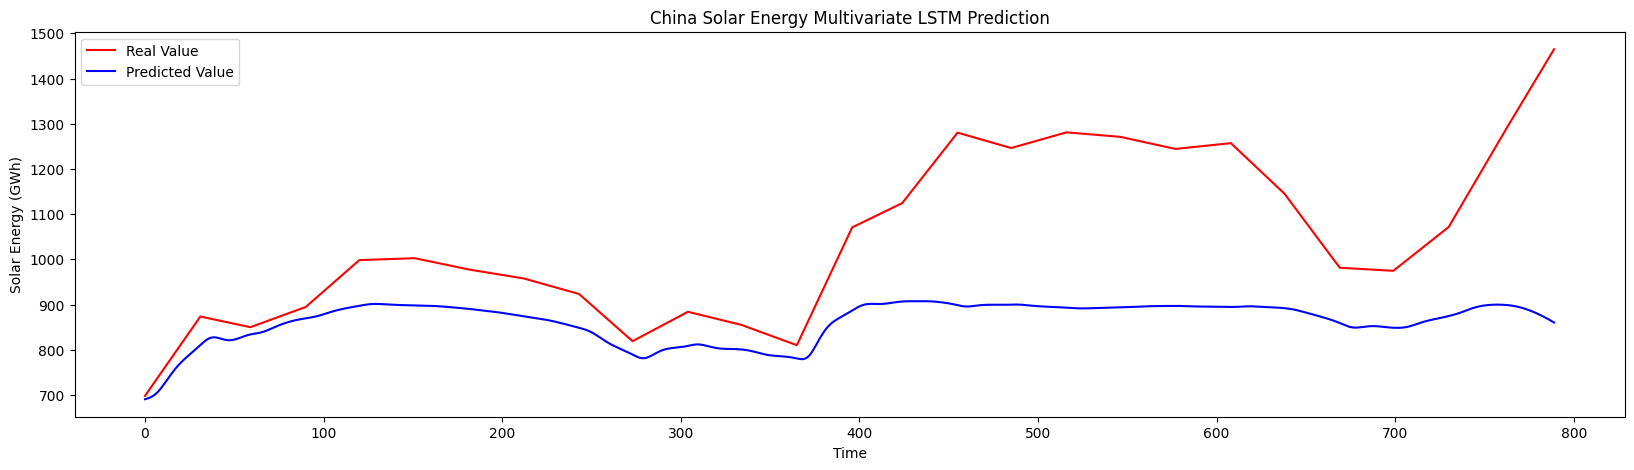

In [82]:
# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(real_value, color='red', label='Real Value')
plt.plot(multi_lstm_y_pred, color='blue', label='Predicted Value')
plt.title('China Solar Energy Multivariate LSTM Prediction')
plt.xlabel('Time')
plt.ylabel('Solar Energy (GWh)')
plt.legend()
plt.show()

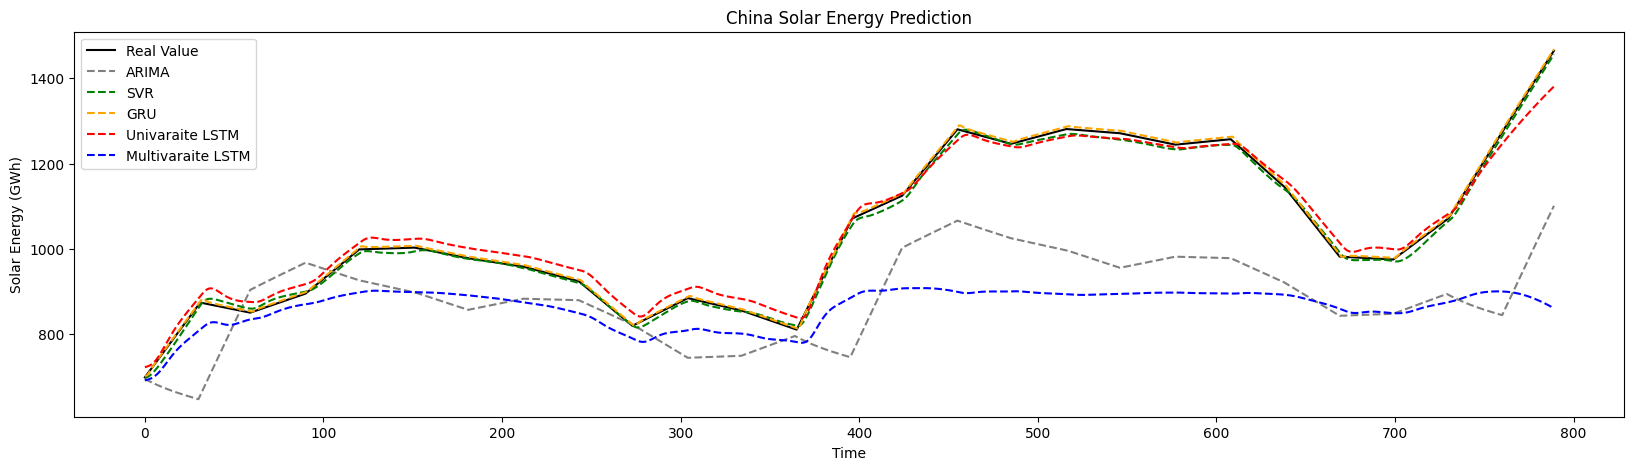

In [90]:
# Overview

# Visualising the results
plt.figure(figsize=(20,5))
plt.plot(real_value, color='black', label='Real Value')
plt.plot(predictions.rx('mean')[0], color='grey', linestyle='--', label='ARIMA')
plt.plot(svr_y_pred, color='green', linestyle='--', label='SVR')
plt.plot(gru_y_pred, color='orange', linestyle='--', label='GRU')
plt.plot(uni_lstm_y_pred, color='red', linestyle='--', label='Univaraite LSTM')
plt.plot(multi_lstm_y_pred, color='blue', linestyle='--', label='Multivaraite LSTM')
plt.title('China Solar Energy Prediction')
plt.xlabel('Time')
plt.ylabel('Solar Energy (GWh)')
plt.legend()
plt.show()

# Save Best Model

In [50]:
chn_daily_gru.save("chn_solar_best_gru.h5")

C:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
